In [67]:
import momepy
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from libpysal.weights import Queen, Rook, KNN
%matplotlib inline

In [68]:
parcels = gpd.read_file('parcels_wdev2.shp')

In [69]:
parcels.head()

,ID,geometry
0,0,"POLYGON ((481396.746 4400046.458, 481396.723 4..."
1,1,"POLYGON ((481673.918 4399842.686, 481685.275 4..."
2,2,"POLYGON ((481661.127 4399939.275, 481664.542 4..."
3,3,"POLYGON ((481652.417 4399951.504, 481658.480 4..."
4,4,"POLYGON ((481664.542 4399934.494, 481670.605 4..."


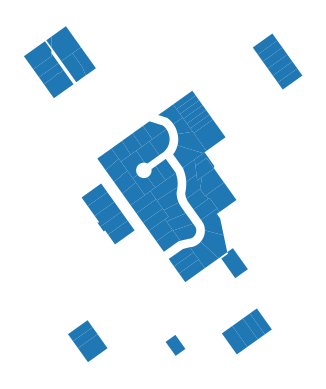

In [70]:
ax = parcels.plot()
ax.set_axis_off()

In [71]:
crs = parcels.estimate_utm_crs().to_epsg()
parcels = parcels.to_crs(crs)

In [72]:
def build_tessellation(df, unique_id, limit):
    limit = momepy.buffered_limit(df, buffer=limit)
    tessellation = momepy.Tessellation(df, unique_id=unique_id, limit=limit)
    tessellation_gdf = tessellation.tessellation

    return tessellation_gdf

In [73]:
og_tess = build_tessellation(parcels, 'ID', 1)
og_tess.to_file('og_tess.shp')

Inward offset...
Generating input point array...
Generating Voronoi diagram...
Generating GeoDataFrame...
Dissolving Voronoi polygons...


<Axes: >

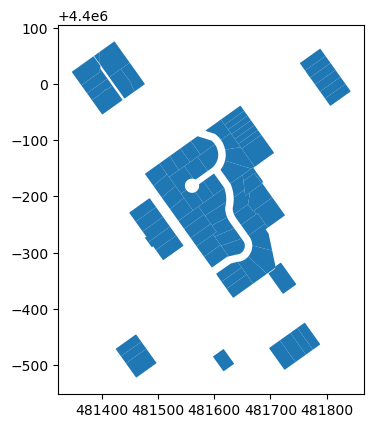

In [74]:
og_tess.plot()

In [75]:
def build_spatial_topology(df, contiguity, unique_id):
    if contiguity == 'rook':
        w = Rook.from_dataframe(df)
    elif contiguity == 'queen':
        w = Queen.from_dataframe(df)
    else:
        raise ValueError('Unknown contiguity type')

    return w

def get_components(df, w):
    # get component labels
    components = w.component_labels
    combined_polygons = df.dissolve(by=components)
    return combined_polygons

In [76]:
w_rook = build_spatial_topology(og_tess, 'rook', 'ID')

d:\mini-forge\envs\growth_model\Lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 9 disconnected components.
 There is 1 island with id: 0.
  warnings.warn(message)


<Axes: >

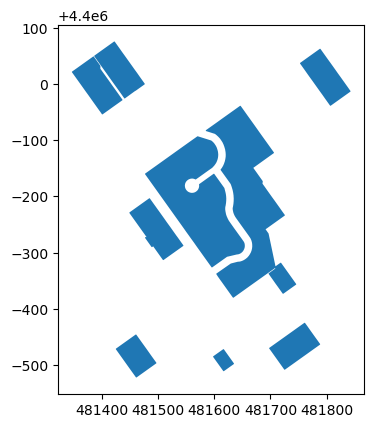

In [77]:
combine = get_components(og_tess, w_rook)
combine.plot()


In [78]:
def get_distance(df, dist_band):
    for poly in range(len(df)):
        ID = df.iloc[poly].ID
        # Calcualtes distance for each point from each df. If Point resides along edge of df( within 1-meter), distance is is given NUll then dropped
        df[f'd_to_{ID}'] = (df.apply(lambda x: 
                                                df.iloc[poly].geometry.distance(x['geometry']) 
                                                if df.iloc[poly].geometry.distance(x['geometry']) < dist_band 
                                                else 0, axis=1)
                                                )
    
    return df

Getting distance between each enclosure. Band is set to 15 meters.

In [79]:
combine = get_distance(combine, dist_band=15.0)
combine.head()

,geometry,ID,d_to_36,d_to_18,d_to_30,d_to_45,d_to_34,d_to_37,d_to_22,d_to_48,d_to_41
0,"POLYGON ((481635.059 4399502.366, 481635.020 4...",36,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,"POLYGON ((481669.145 4399644.884, 481634.474 4...",18,0.0,0.000000,12.955754,0.0,0.0,0.0,0.0,0.0,0.0
2,"POLYGON ((481555.293 4399729.957, 481550.856 4...",30,0.0,12.955754,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,"POLYGON ((481479.409 4399529.315, 481479.412 4...",45,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,"POLYGON ((481535.150 4399727.063, 481536.174 4...",34,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
def identify_limits(df):
    cols = df.filter(regex='d_to_')
    df['limit'] = df[cols.columns.to_list()].sum(axis=1)
    return df

In [81]:
combine = identify_limits(combine)
combine.head()

,geometry,ID,d_to_36,d_to_18,d_to_30,d_to_45,d_to_34,d_to_37,d_to_22,d_to_48,d_to_41,limit
0,"POLYGON ((481635.059 4399502.366, 481635.020 4...",36,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,"POLYGON ((481669.145 4399644.884, 481634.474 4...",18,0.0,0.000000,12.955754,0.0,0.0,0.0,0.0,0.0,0.0,12.955754
2,"POLYGON ((481555.293 4399729.957, 481550.856 4...",30,0.0,12.955754,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,12.955754
3,"POLYGON ((481479.409 4399529.315, 481479.412 4...",45,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,"POLYGON ((481535.150 4399727.063, 481536.174 4...",34,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [82]:
def get_adj_id(x):
    ids = []
    x = dict(x.filter(regex='d_to_'))
    for col, row in x.items():
        if row != 0:
            ids.append(col.split('_')[-1]) 
    
    return ids


In [83]:
combine['adjacent_ID'] = combine.apply(lambda x: get_adj_id(x), axis=1)

In [84]:
combine.head()

,geometry,ID,d_to_36,d_to_18,d_to_30,d_to_45,d_to_34,d_to_37,d_to_22,d_to_48,d_to_41,limit,adjacent_ID
0,"POLYGON ((481635.059 4399502.366, 481635.020 4...",36,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,[]
1,"POLYGON ((481669.145 4399644.884, 481634.474 4...",18,0.0,0.000000,12.955754,0.0,0.0,0.0,0.0,0.0,0.0,12.955754,[30]
2,"POLYGON ((481555.293 4399729.957, 481550.856 4...",30,0.0,12.955754,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,12.955754,[18]
3,"POLYGON ((481479.409 4399529.315, 481479.412 4...",45,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,[]
4,"POLYGON ((481535.150 4399727.063, 481536.174 4...",34,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,[]


Idenityfing the candidate enclosures for merging. 

In [85]:
merge = combine[combine['limit'] != 0]
merge

,geometry,ID,d_to_36,d_to_18,d_to_30,d_to_45,d_to_34,d_to_37,d_to_22,d_to_48,d_to_41,limit,adjacent_ID
1,"POLYGON ((481669.145 4399644.884, 481634.474 4...",18,0.0,0.000000,12.955754,0.0,0.0,0.0,0.000000,0.0,0.000000,12.955754,[30]
2,"POLYGON ((481555.293 4399729.957, 481550.856 4...",30,0.0,12.955754,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,12.955754,[18]
6,"POLYGON ((481423.468 4399990.705, 481427.908 4...",22,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.984371,0.984371,[41]
8,"POLYGON ((481454.322 4400031.363, 481458.760 4...",41,0.0,0.000000,0.000000,0.0,0.0,0.0,0.984371,0.0,0.000000,0.984371,[22]


In [86]:
merge = merge[['ID', 'limit', 'adjacent_ID', 'geometry']]

The below process iterates through each canidate enclsoure and repeats the following steps:
1. Capturing ID and geometry of the candidate enclosure and its adjacent enclosure
2. Builds a new geodataframe from the two enclosures
3. Builds tessellation using the distance between them as the new limit parameter
4. Builds spatial weights matrix
5. Combines the two enclosures
6. Runs a spatial join to identify the original parcel IDs that the new merged enclosure intersects
7. Appends the IDs to a list
8. Builds the the final tessellation on the orignal parcels selected from the spatial join (using the limit parameter + 5 meters)
9. Appends the tessellation to a running geodataframe

In [87]:
remove_ids = []
tessellations = gpd.GeoDataFrame()
for index, row in merge.iterrows():
    ID = row.ID
    adjacent_ID = row.adjacent_ID[0]
    limit = row.limit
    geometry = row.geometry
    adj_geometry = merge[merge['ID'] == int(adjacent_ID)].geometry.values[0]
    df = gpd.GeoDataFrame(geometry=[geometry, adj_geometry], crs=merge.crs.to_epsg())
    df['ID'] = df.index

    tess = build_tessellation(df, 'ID', limit)
    w = build_spatial_topology(tess, 'rook', 'ID')
    combine = get_components(tess, w)

    sel_parcels = parcels.sjoin(combine, how='inner', op='intersects')
    sel_parcels = sel_parcels[['ID_left', 'geometry']].rename(columns={'ID_left': 'ID'})
    remove_ids.append(sel_parcels.ID.to_list())
    sel_tess = build_tessellation(sel_parcels, 'ID', (limit + 5))
    
    tessellations = pd.concat([tessellations, sel_tess], ignore_index=True)


    
    
    
    



    

Inward offset...
Generating input point array...
Generating Voronoi diagram...
Generating GeoDataFrame...
Dissolving Voronoi polygons...


d:\mini-forge\envs\growth_model\Lib\site-packages\IPython\core\interactiveshell.py:3508: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


Inward offset...
Generating input point array...
Generating Voronoi diagram...
Generating GeoDataFrame...
Dissolving Voronoi polygons...
Inward offset...
Generating input point array...
Generating Voronoi diagram...
Generating GeoDataFrame...
Dissolving Voronoi polygons...


d:\mini-forge\envs\growth_model\Lib\site-packages\IPython\core\interactiveshell.py:3508: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


Inward offset...
Generating input point array...
Generating Voronoi diagram...
Generating GeoDataFrame...
Dissolving Voronoi polygons...
Inward offset...
Generating input point array...
Generating Voronoi diagram...
Generating GeoDataFrame...
Dissolving Voronoi polygons...


d:\mini-forge\envs\growth_model\Lib\site-packages\IPython\core\interactiveshell.py:3508: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


Inward offset...
Generating input point array...
Generating Voronoi diagram...
Generating GeoDataFrame...
Dissolving Voronoi polygons...
Inward offset...
Generating input point array...
Generating Voronoi diagram...
Generating GeoDataFrame...
Dissolving Voronoi polygons...


d:\mini-forge\envs\growth_model\Lib\site-packages\IPython\core\interactiveshell.py:3508: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


Inward offset...
Generating input point array...
Generating Voronoi diagram...
Generating GeoDataFrame...
Dissolving Voronoi polygons...


Drops the duplicate process from the final geodataframe.

<Axes: >

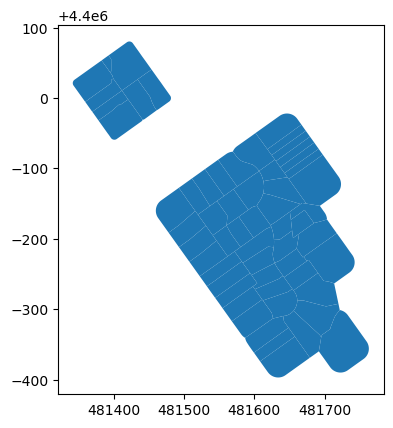

In [88]:
tessellations_clean = tessellations.drop_duplicates()
tessellations_clean.plot()


In [89]:
tessellations_clean.to_file('tessellations_clean.shp')

Clean list of IDs that were processed. (Process created nestd lists)

In [90]:
remove_ids = [item for sublist in remove_ids for item in sublist]
remove_ids = list(set(remove_ids))

Locate the parcel IDs that were tessellated through the above process and remove them from the original tessellation. The remaining tesselations
were not merged with any other enclosures.

In [91]:
og_tess = og_tess[~og_tess['ID'].isin(remove_ids)]
all_tess = pd.concat([og_tess, tessellations_clean], ignore_index=True)
all_tess.to_file('all_tess.shp')

Build Final Weights matrix

In [92]:
w_rook_final = build_spatial_topology(all_tess, 'rook', 'ID')

d:\mini-forge\envs\growth_model\Lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There is 1 island with id: 0.
  warnings.warn(message)


List out neighbors for each ID

In [93]:
all_ids = w_rook_final.id_order

In [94]:
for i in all_ids:
    print(f'ID: {i}: {w_rook_final.neighbors[i]}')

ID: 0: []
ID: 1: [2]
ID: 2: [1, 3]
ID: 3: [2]
ID: 4: [5]
ID: 5: [4, 6]
ID: 6: [5, 7]
ID: 7: [8, 6]
ID: 8: [7]
ID: 9: [10]
ID: 10: [9, 11]
ID: 11: [10, 12]
ID: 12: [11]
ID: 13: [14]
ID: 14: [13, 15]
ID: 15: [16, 14]
ID: 16: [17, 15]
ID: 17: [16, 18]
ID: 18: [17]
ID: 19: [20, 30]
ID: 20: [19, 21, 30]
ID: 21: [20, 30, 22, 39]
ID: 22: [40, 39, 21, 23]
ID: 23: [24, 41, 40, 22]
ID: 24: [25, 43, 41, 23]
ID: 25: [24, 26, 43, 45]
ID: 26: [25, 27, 45, 46]
ID: 27: [26, 28, 46]
ID: 28: [56, 50, 27, 46]
ID: 29: [30, 31]
ID: 30: [19, 20, 21, 39, 29, 31]
ID: 31: [32, 29, 30, 39]
ID: 32: [33, 34, 31, 39]
ID: 33: [32, 34, 39, 40, 42]
ID: 34: [32, 33, 42, 35]
ID: 35: [34, 36, 37, 42, 44]
ID: 36: [48, 35, 44, 37]
ID: 37: [48, 51, 35, 36, 53, 38]
ID: 38: [37, 53, 63]
ID: 39: [32, 33, 21, 22, 40, 30, 31]
ID: 40: [33, 39, 22, 23, 41, 42]
ID: 41: [23, 40, 24, 42, 43]
ID: 42: [33, 34, 35, 40, 41, 43, 44]
ID: 43: [24, 25, 42, 44, 45, 41]
ID: 44: [48, 35, 36, 42, 43, 45]
ID: 45: [43, 44, 46, 47, 48, 49, 25, 26]